<a href="https://colab.research.google.com/github/tejash0901/DNA-sequence-classification-using-RRCNN-and-Bi-LSTM/blob/main/Without_oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
classesDict = {0: "COVID", 1: "DENGUE", 2: "EBOLA", 3: "MERS", 4: "SARS"}

attributes_list = []
classes_list = []
attrsSize = 0

In [ ]:
for key in classesDict:
    fasta_file = "/content/drive/MyDrive/data/sequences" + classesDict[key] + ".fasta"
    fasta_sequences = SeqIO.parse(open(fasta_file), 'fasta')
    i=0
    for fasta in fasta_sequences:
      i+=1
      attributes_list.append(str(fasta.seq))
      classes_list.append(key)
      if(i==500):
        break

    class_size = len(classes_list) - attrsSize
    print("class", classesDict[key], "size:", class_size)
    attrsSize = len(attributes_list)

attributes = np.array(attributes_list)
classes = np.array(classes_list)

print("total attributes size: ", attributes.shape[0])
print("total classes size: ", classes.shape[0])

class COVID size: 500
class DENGUE size: 500
class EBOLA size: 500
class MERS size: 500
class SARS size: 500
total attributes size:  2500
total classes size:  2500


In [ ]:
attributes = attributes.reshape(-1, 1)
maxSequence = 6000
X_resBinarized = np.zeros((len(attributes), maxSequence, 1), dtype=np.uint8)
for i, sequence in enumerate(attributes):
    sequenceStr = sequence[0]
    sequenceBinarizedStr = ""
    index = 0
    for char in sequenceStr:
        if index < maxSequence:
            if char == 'a':
                sequenceBinarizedStr += "1"
            elif char == 'c':
                sequenceBinarizedStr += "2"
            elif char == 'g':
                sequenceBinarizedStr += "3"
            elif char == 't':
                sequenceBinarizedStr += "4"
            else:
                sequenceBinarizedStr += "0"
        index += 1

    if len(sequenceStr) < maxSequence:
        sequenceLength = len(sequenceStr)
        while sequenceLength < maxSequence:
            sequenceBinarizedStr += "0"
            sequenceLength += 1

    sequenceBinarized = np.array(list(sequenceBinarizedStr), dtype=np.uint8)
    X_resBinarized[i] = sequenceBinarized.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X_resBinarized, classes, test_size=0.3, random_state=4, stratify=classes)

print("x_train size: ", x_train.shape[0])
print("y_train size: ", y_train.shape[0])
print("x_test size: ", x_test.shape[0])
print("y_test size: ", y_test.shape[0])

x_train size:  1750
y_train size:  1750
x_test size:  750
y_test size:  750


In [ ]:
batch_size = 32
num_classes = 5
epochs = 5

vocab_size = 5
embedding_dim = 8
maxlen= x_train[0].size


# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_test1 = np.argmax(y_test, axis=1)
y_train1 = np.argmax(y_train, axis=1)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Concatenate, Reshape, Add

# Define input layer
inputs = Input(shape=(maxlen,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inputs)

# Recurrent Residual Convolutional Network (RRCN)
conv1 = Conv1D(128, 2, activation='relu', padding='same')(embedding_layer)
conv1_res = Conv1D(128, 2, activation='relu', padding='same')(conv1)
conv1_res = Add()([conv1, conv1_res])  # Residual connection
pool1 = MaxPooling1D(pool_size=2)(conv1_res)

conv2 = Conv1D(64, 2, activation='relu', padding='same')(pool1)
conv2_res = Conv1D(64, 2, activation='relu', padding='same')(conv2)
conv2_res = Add()([conv2, conv2_res])  # Residual connection
pool2 = MaxPooling1D(pool_size=2)(conv2_res)

flatten = Flatten()(pool2)

# Bidirectional LSTM layer
lstm_input = Reshape((-1, 64))(conv2_res)  # Reshape for LSTM input
bidirectional_lstm = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(lstm_input)

# Concatenate the output of RRCN and Bidirectional LSTM
concatenated = Concatenate()([flatten, bidirectional_lstm])

# Dense layers
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(num_classes, activation='softmax')(dense2)

# Create the model
hybrid_model = Model(inputs=inputs, outputs=output_layer)

hybrid_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 6000, 8)              40        ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 6000, 128)            2176      ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 6000, 128)            32896     ['conv1d[0][0]']              
                                                                                              

In [ ]:
hybrid_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=hybrid_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/5
55/55 [==============================] - 438s 8s/step - loss: 0.6877 - accuracy: 0.7371 - val_loss: 0.3027 - val_accuracy: 0.8773
Epoch 2/5
55/55 [==============================] - 442s 8s/step - loss: 0.2642 - accuracy: 0.9057 - val_loss: 0.2273 - val_accuracy: 0.9120
Epoch 3/5
55/55 [==============================] - 438s 8s/step - loss: 0.1319 - accuracy: 0.9497 - val_loss: 0.2065 - val_accuracy: 0.9360
Epoch 4/5
55/55 [==============================] - 440s 8s/step - loss: 0.0865 - accuracy: 0.9674 - val_loss: 0.1902 - val_accuracy: 0.9507
Epoch 5/5
55/55 [==============================] - 442s 8s/step - loss: 0.0970 - accuracy: 0.9777 - val_loss: 0.1378 - val_accuracy: 0.9613


In [ ]:
score = hybrid_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
y_predicted = hybrid_model.predict(x_test)
print("Prediction: ", y_predicted)

24/24 [==============================] - 28s 1s/step
Prediction:  [[6.7699333e-03 7.7929404e-03 4.3099189e-01 1.0833964e-02 5.4361123e-01]
 [9.8313450e-30 0.0000000e+00 9.9999994e-01 1.5082007e-26 2.0316225e-24]
 [1.0133989e-29 0.0000000e+00 9.9999994e-01 1.5290206e-26 1.9805895e-24]
 ...
 [7.0257440e-15 5.0069087e-19 1.7521883e-11 1.0000000e+00 2.9312837e-13]
 [7.0256902e-15 5.0068705e-19 1.7521750e-11 1.0000000e+00 2.9312669e-13]
 [3.7812734e-19 6.3055199e-14 9.6839845e-15 5.0477411e-14 1.0000000e+00]]


In [ ]:
y_pred_labels = np.argmax(y_predicted, axis=1)

Confusion matrix
[[149   0   0   0   1]
 [  0 145   0   2   3]
 [  0   0 137   2  11]
 [  0   0   2 142   6]
 [  0   1   0  13 136]]

Classification report
              precision    recall  f1-score   support

       covid       1.00      0.99      1.00       150
      dengue       0.99      0.97      0.98       150
       ebola       0.99      0.91      0.95       150
        Mers       0.89      0.95      0.92       150
        Sars       0.87      0.91      0.89       150

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



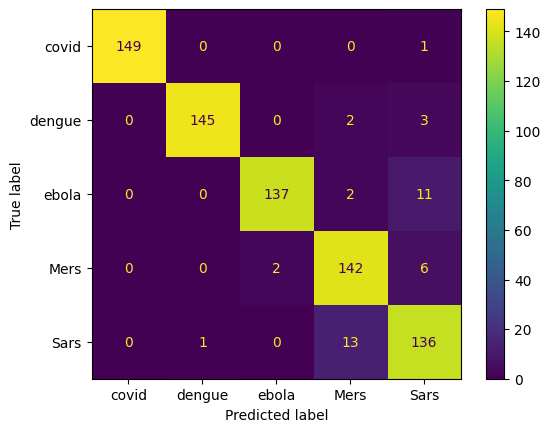

In [ ]:
from sklearn import metrics

print("Confusion matrix")
confusion_matrix = metrics.confusion_matrix(y_true=y_test1, y_pred=y_pred_labels)
print(confusion_matrix)
target_names = ['covid','dengue','ebola','Mers', 'Sars']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=target_names)
disp.plot()

print()
print("Classification report")
report = metrics.classification_report(y_test1, y_pred_labels, target_names=target_names)
print(report)